## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

### Final exam

**Harvard University**  
**Spring 2017**  
**Instructor: Rahul Dave**  
**Due Date:** 

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1. A Hierarchical Artificial Neural Network Using Variational Inference

We have learned in this course to create automatic classifiers. In such supervised algorithms,  a function is learned that maps certain input data to a set of outputs, usually the classes into which the dataset wants to be separated. This is achieved by iteratively updating the weights that regulate the flow of information between different layers of an artificial neural network (ANN). We have also seen that it is possible to regularize by penalizing some weights in order to avoid overfitting. This regularization is equivalent to imposing priors on the weights when they are initialized.

This approach is inherently Bayesian. We can specify priors to inform and constrain our models and get uncertainty estimations in form of a posterior distribution. Using MCMC sampling algorithms we can draw samples from this posterior to very flexibly estimate these models. This also means that we can obtain uncertainties on both the weights and the classes that we obtain from the output layer.

In this problem you are asked to build a hierarchical Bayesian ANN to classify the MNIST dataset (properly split into training and test sets) that we have used before, and to infer uncertainties for the weighths and the resulting classes. Variational inference can become very handy here: instead of drawing samples from the posterior, these algorithms fit a distribution (e.g. normal) to the posterior turning a sampling problem into and optimization problem. ADVI -- Automatic Differentation Variational Inference is implemented in PyMC3 and Stan. 

### Part A
Build an artificial neural network with two hidden units and 25 neurons each, and use it to classify the MNIST dataset. Use the $\tanh$ function as the non-linearity, and initialize the weights using using normal priors with $\mu=0$ and fixed $\sigma = 0.1$.

1. At this point, you could use a MCMC sampler such as NUTS to train your model. But this could be extremely slow as you add more layer or more units. Instead, use the PyMC3 ADVI implementation to approximate the posteriors of the weights, and obtain the posterior means, standard deviations, and the evidence lower bound (ELBO), which is your objective function. Use mini-batch gradient descent for the optimization, and a todal of 50000 ADVI iterations.

2. Plot the objective function (ELBO) as a function of the iteration. Using the best fit from your training, predict on the test set by estimating posterior predictives for the classes in each case, and provide the accuracy of your classification. How does your accuracy compare to the single-layer perceptron of Long HW1? *Hint: if you need traces to perform inference, you can sample directly from the normal distribution that ADVI outputs*.

3. Produce a 2D visualization of the resulting weight posteriors. Plot the means and uncertainties of the resulting posteriors in a 2D grid with dimensions equal to the pixel arrangment in each of the MNIST images. You need to do this only for one of the units in the ANN.

### Part B
The connection between the standard deviation of the weight prior to the strengh of the L2 penalization term leads to an interesting idea. In Part A we fixed $\sigma=0.1$, but this is a somehow arbitrary decision. Perhaps $\sigma$ should be different for each layer, and have a different magnitude. Rather than randomly trying different $\sigma$s, we can learn the best values directly from the data. This is when the ANN becomes hierarchical. 

1. Modify your algorithm to include hyperpriors for the $\sigma$s, and use ADVI again to optimize the model Plot the posteriors distributions for the hyperpriors.

2. Just as in part A, predict on the test data. This time, plot the resulting confusion matrix to visualize the accuracy of your result.

3. You can now use the fact that we're in a Bayesian framework and explore uncertainty in your predictions. Compute the $\chi^2$ statistic for the predictions and see how uniform the samples are. The more uniform, the higher our uncertainty. Plot histogrmas of the $\chi^2$ statistic for those predictions that you got right with respect to the test set, and for those that you got wrong. What is your conclusion?





In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import gzip
import pickle
from scipy.stats import mode, chisquare

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load MNIST dataset
dataset='/Users/jmartine/teaching/logistic_sgd/mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

In [3]:
X_train = train_set[0]
Y_train = train_set[1]

X_test = test_set[0]
Y_test = test_set[1]

In [4]:
n_hidden =  25  # Number of hidden units

In [5]:
#ann_input = theano.shared(X_train)
#ann_output = theano.shared(Y_train)

input_var = theano.shared(X_train[:500, ...].astype(np.float64))
target_var = theano.shared(Y_train[:500, ...].astype(np.float64))

In [6]:
def build_ann():
    
    regularization1 = pm.HalfNormal('reg_hyper1', sd=1)
    
    bias_in_1 = pm.Normal('b_in_1', mu=0, sd=regularization1, 
                         shape=n_hidden)
    
    regularization2 = pm.HalfNormal('reg_hyper2', sd=1)
    
    weights_in_1 = pm.Normal('w_in_1', mu=0, sd=regularization2, 
                         shape = (X_train.shape[1], n_hidden))   
    # Build a layer using tanh activation function
    act_1 = T.tanh(T.dot(input_var, 
                         weights_in_1) + bias_in_1)
    
    regularization3 = pm.HalfNormal('reg_hyper3', sd=1)
    
    bias_1_2 = pm.Normal('b_1_2', mu=0, sd=regularization3, 
                         shape=n_hidden)
    
    regularization4 = pm.HalfNormal('reg_hyper4', sd=1)
    
    weights_1_2 = pm.Normal('w_1_2', mu=0, sd=regularization4, 
                         shape = (n_hidden, n_hidden))   
    # Build a layer using tanh activation function
    act_2 = T.tanh(T.dot(act_1, 
                         weights_1_2) + bias_1_2)
    
    regularization5 = pm.HalfNormal('reg_hyper5', sd=1)
    
    bias_2_out = pm.Normal('b_2_out', mu=0, sd=regularization5, 
                         shape=len(np.unique(Y_train)))
    
    regularization6 = pm.HalfNormal('reg_hyper6', sd=1)
    
    weights_2_out = pm.Normal('w_2_out', mu=0, sd=regularization6, 
                         shape = (n_hidden,len(np.unique(Y_train))))   
    # Build a layer using tanh activation function
    act_out = T.nnet.softmax(T.dot(act_2, weights_2_out) + bias_2_out)
    
    # 10 discrete output classes -> pymc3 categorical distribution
    out = pm.Categorical('out', 
                         act_out,
                         observed=target_var)
    return out

In [7]:
from six.moves import zip

# Tensors and RV that will be using mini-batches
minibatch_tensors = [input_var,target_var]

# Generator that returns mini-batches in each iteration
def create_minibatch(data, batchsize=500):
    
    rng = np.random.RandomState(0)
    start_idx = 0
    while True:
        # Return random data samples of set size batchsize each iteration
        ixs = rng.randint(data.shape[0], size=batchsize)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(Y_train, 500),
)

total_size = len(Y_train)

def run_advi(likelihood, advi_iters=50000):
    # Train on train data
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(Y_train[:500, ...])
    
    v_params = pm.variational.advi_minibatch(
        n=advi_iters, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=[likelihood], minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )
    trace = pm.variational.sample_vp(v_params, draws=500)
    
    # Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(Y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred

In [8]:
with pm.Model() as neural_network:
    likelihood = build_ann()
    v_params, trace, ppc, y_pred = run_advi(likelihood)
    
    
#from pymc3 import find_MAP,NUTS, sample
#from scipy import optimize
#advi_iters = 50000

#with neural_network:
    
#    # Initialize with ADVI
#    mu, sds, elbo = pm.variational.advi_minibatch(
#        n=advi_iters, minibatch_tensors=minibatch_tensors, 
#        minibatch_RVs=[likelihood], minibatches=minibatches, 
#        total_size=total_size, learning_rate=1e-2, epsilon=1.0)
    
#    # instantiate sampler
#    step = pm.NUTS(scaling=neural_network.dict_to_array(sds)**2, 
#                   is_cov=True)
    
#    # draw 5000 posterior samples
#    trace = pm.sample(5000, step, start=mu)

100%|██████████| 100/100 [00:25<00:00,  4.49it/s]


In [9]:
print(y_pred)

[7 2 1 ..., 4 5 6]


In [10]:
with neural_network:    
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:06<00:00, 724.95it/s]


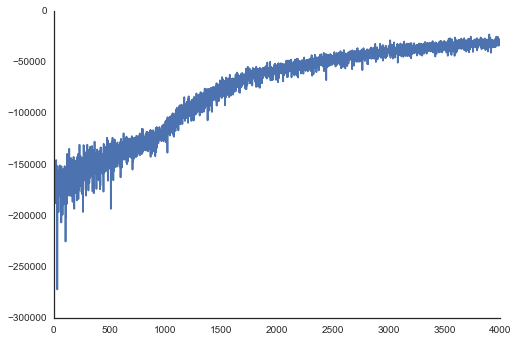

In [11]:
plt.plot(v_params.elbo_vals[10000:])
sns.despine()

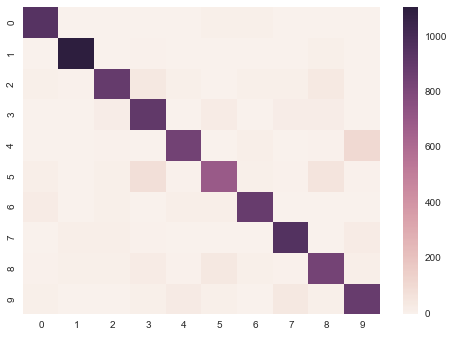

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
sns.heatmap(confusion_matrix(Y_test, y_pred))

In [13]:
print('Accuracy on test data = {}%'.format(accuracy_score(Y_test, y_pred) * 100))

Accuracy on test data = 89.75%


In [27]:
print(shape(trace['reg_hyper1']))
print(shape(trace['w_in_1']))

(5000,)
(5000, 784, 25)


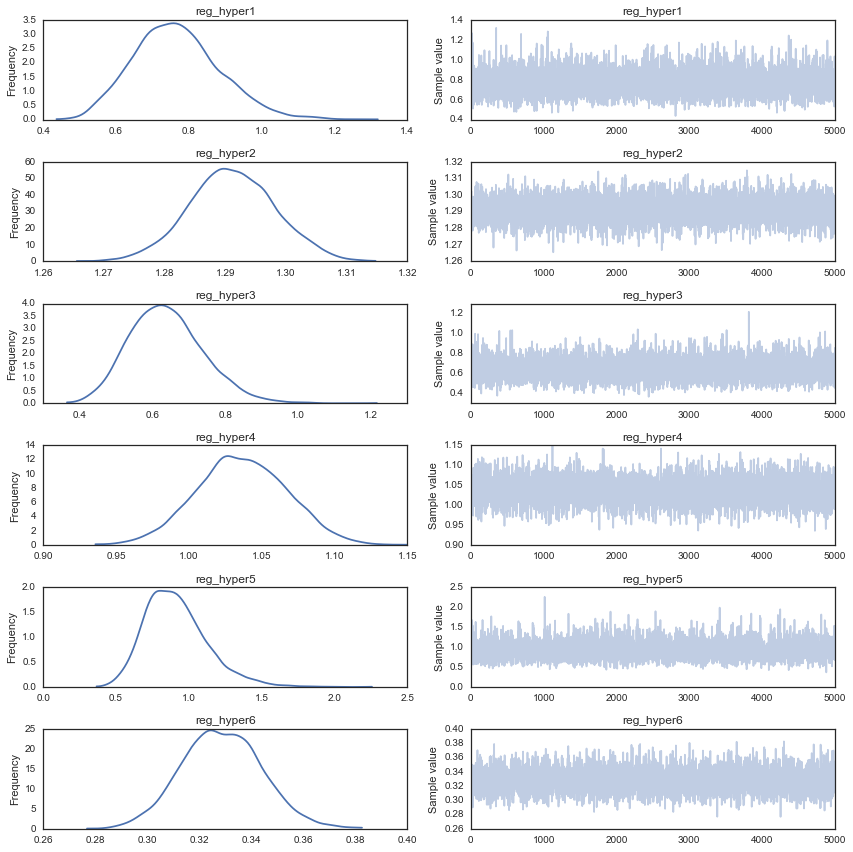

In [14]:
pm.traceplot(trace, varnames=['reg_hyper1', 'reg_hyper2', 'reg_hyper3', 'reg_hyper4', 'reg_hyper5', 'reg_hyper6']);

In [37]:
#plt.hist(trace['w_in_1'][:,300,0])
#print(shape(trace['w_in_1']))

means = []
stds = []
for i in range(784):
    if (i%10 == 0): print(i)
    mean1 = np.mean(trace['w_in_1'][:,i,0])
    std1 = np.std(trace['w_in_1'][:,i,0])
    means.append(mean1)
    stds.append(std1)
    
np.reshape(means,(28,28))
np.reshape(stds,(28,28))

print,means

#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
#fig, ax = plt.subplots(figsize=(10, 6))
#contour = ax.contourf(X, Y, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780


(<function print>,
 [0.01426722315308121,
  0.057571699884530855,
  -0.026538007395167408,
  -0.049164271334829202,
  -0.023922922930059973,
  -0.036141441106959556,
  0.037771539591571736,
  -0.055132672770869418,
  -0.031048201082980315,
  0.083285965252556771,
  0.12737481109742299,
  0.043366417424849264,
  -0.017485597059616418,
  -0.022230156326986616,
  0.055679580075583331,
  0.10781121241930851,
  0.129581093959311,
  0.038888963954791085,
  -0.0066861947385808375,
  -0.038503104026497349,
  -0.024509183796248855,
  0.014867218562383943,
  0.037122395263682231,
  0.017748662699414608,
  0.11501960052435939,
  0.03175514913521553,
  -0.12157800302046978,
  0.0086398710640885352,
  0.0067438234227927153,
  0.0400084220208567,
  -0.051740364697984202,
  -0.024928487417561828,
  0.0029961728697824098,
  0.032305439042200707,
  -0.00051113452670230254,
  -0.037942513539167395,
  -0.078986032628864014,
  -0.051677036919256535,
  -0.1097111488720401,
  -0.090196617238478619,
  0.0824

In [39]:
B = np.reshape(means, (28, 28))
print(shape(B))

(28, 28)


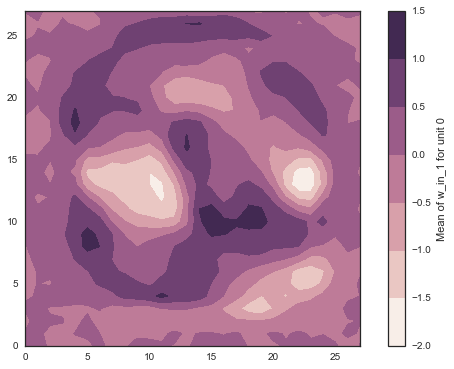

In [60]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(B, cmap=cmap)
cbar = plt.colorbar(contour, ax=ax)
#plt.axis('equal')
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Mean of w_in_1 for unit 0');
#plt.tight_layout()

ax.set_aspect('equal')

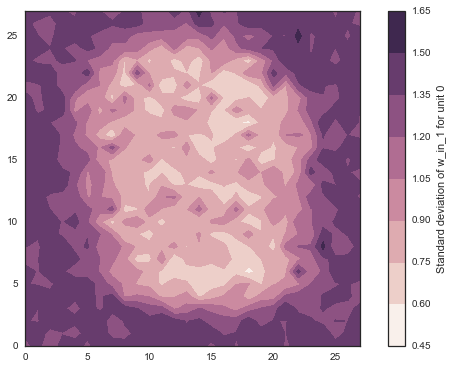

In [61]:
C = np.reshape(stds, (28, 28))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(C, cmap=cmap)
cbar = plt.colorbar(contour, ax=ax)
#plt.axis('equal')
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Standard deviation of w_in_1 for unit 0');
#plt.tight_layout()

ax.set_aspect('equal')

In [15]:
miss_class = np.where(Y_test != y_pred)[0]
corr_class = np.where(Y_test == y_pred)[0]

In [16]:
print(corr_class)

[   0    1    2 ..., 9997 9998 9999]


In [17]:
import pandas as pd
preds = pd.DataFrame(ppc['out']).T

In [18]:
chis = preds.apply(lambda x: chisquare(x).statistic, axis='columns')

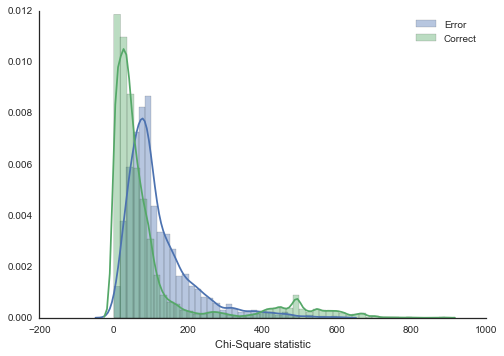

In [20]:
sns.distplot(chis.loc[miss_class].dropna(), label='Error')
sns.distplot(chis.loc[corr_class].dropna(), label='Correct')
plt.legend()
sns.despine()
plt.xlabel('Chi-Square statistic');